In [7]:
pip install raidionicsval@git+https://github.com/dbouget/validation_metrics_computation.git@master#raidionicsval

  Cloning https://github.com/dbouget/validation_metrics_computation.git (to revision master) to /home/dbouget/.tmp/pip-install-3km5bo7b/raidionicsval_dfcadf5e08dc412aa95a82a4dde82ac9
  Running command git clone --filter=blob:none --quiet https://github.com/dbouget/validation_metrics_computation.git /home/dbouget/.tmp/pip-install-3km5bo7b/raidionicsval_dfcadf5e08dc412aa95a82a4dde82ac9
  Resolved https://github.com/dbouget/validation_metrics_computation.git to commit f811702577c7cdaf8d2664c7a06b37c23d59b033
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [14]:
# Download the test data
import os
import requests
import zipfile
resources_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Samples-RaidionicsValLib_UnitTest1.zip'
test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')
os.makedirs(test_dir, exist_ok=True)
print("Test directory: {}".format(test_dir))
archive_dl_dest = os.path.join(test_dir, 'resources.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(resources_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
            
with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
    zip_ref.extractall(test_dir)

print("Raw dataset located in: {}".format(os.path.join(test_dir, "Input_dataset")))
print("Model predictions located in: {}".format(os.path.join(test_dir, "StudyResults")))

Test directory: /home/dbouget/Code/Private/validation_metrics_computation/notebooks/unit_tests_results_dir
Raw dataset located in: /home/dbouget/Code/Private/validation_metrics_computation/notebooks/unit_tests_results_dir/Input_dataset
Model predictions located in: /home/dbouget/Code/Private/validation_metrics_computation/notebooks/unit_tests_results_dir/StudyResults


Running 1-fold cross-validation unit test.
Detection overlap:  [0.0]

Processing fold 0/0.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:54<00:00, 23.47s/it]


Class 'tumor' - Selected values (Overlap: 0.0, Threshold: 0.7) for global metric of 0.9125586642267945. True positive case: False
Class 'tumor' - Selected values (Overlap: 0.0, Threshold: 0.7) for global metric of 0.9125586642267945. True positive case: True
Computing extra metrics for all patients.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.09s/it]


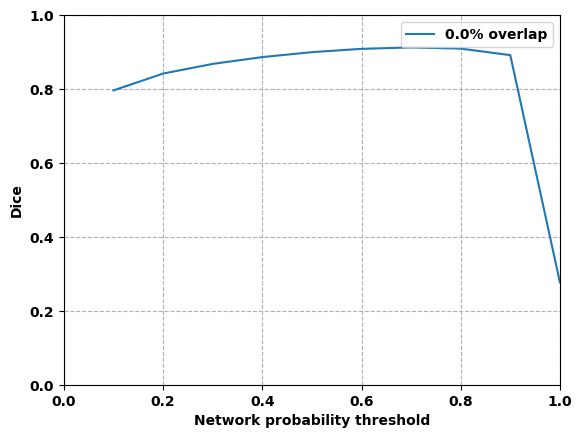

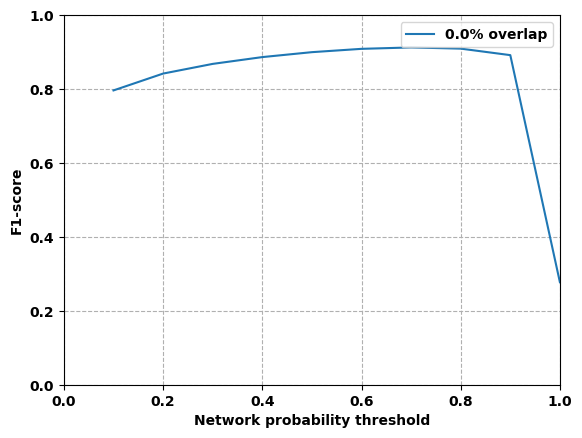

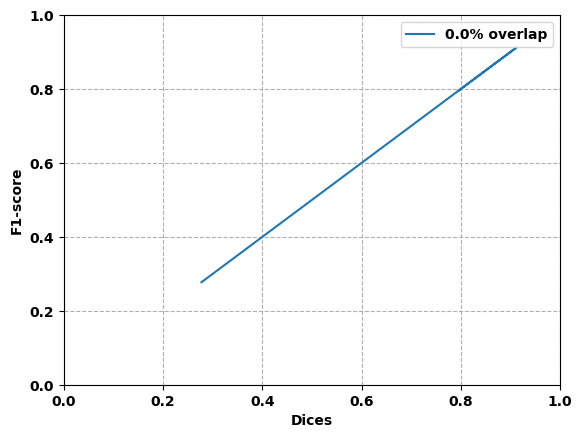

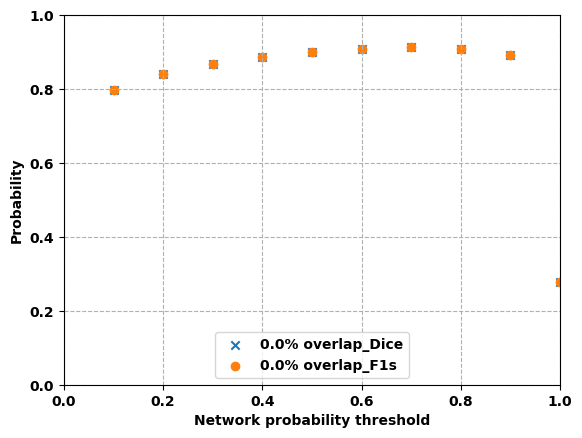

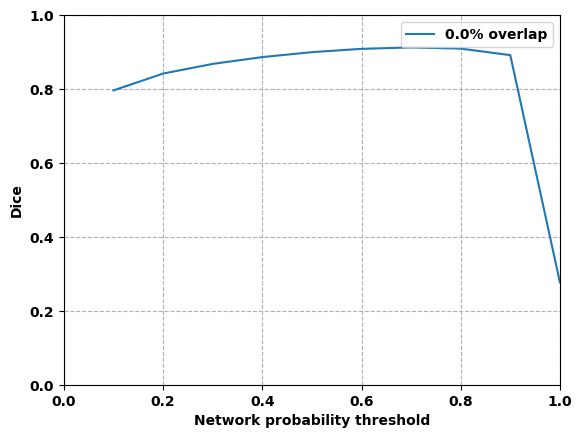

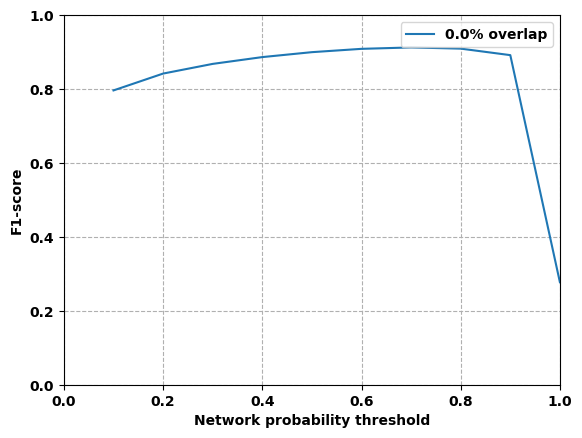

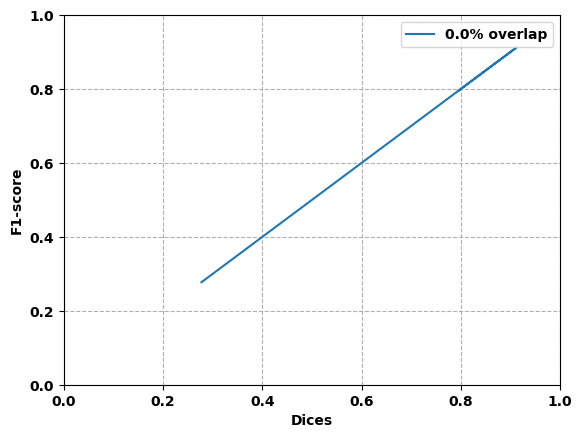

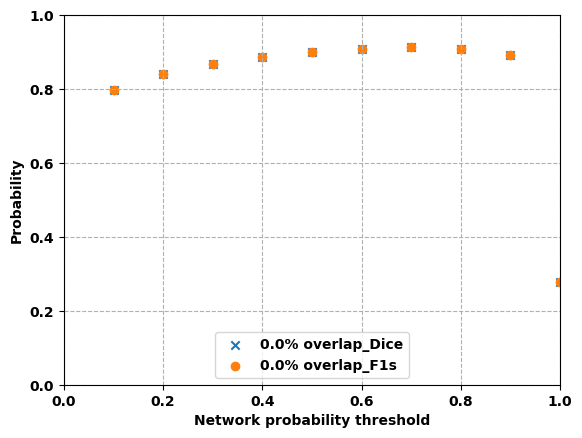

In [15]:
import configparser

val_config = configparser.ConfigParser()
val_config.add_section('Default')
val_config.set('Default', 'task', 'validation')
val_config.set('Default', 'data_root', os.path.join(test_dir, 'Input_dataset'))
val_config.set('Default', 'number_processes', "1")
val_config.add_section('Validation')
val_config.set('Validation', 'input_folder', os.path.join(test_dir, 'StudyResults'))
val_config.set('Validation', 'output_folder', os.path.join(test_dir, 'StudyResults'))
val_config.set('Validation', 'gt_files_suffix', 'label_tumor.nii.gz')
val_config.set('Validation', 'prediction_files_suffix', 'pred_tumor.nii.gz')
val_config.set('Validation', 'use_index_naming_convention', 'false')
val_config.set('Validation', 'nb_folds', '1')
val_config.set('Validation', 'split_way', 'three-way')
val_config.set('Validation', 'detection_overlap_thresholds', '0.')
val_config.set('Validation', 'metrics_space', 'pixelwise, objectwise')
val_config.set('Validation', 'class_names', 'tumor')
val_config.set('Validation', 'extra_metrics', 'TPR, TNR, FPR, FNR, PPV, Jaccard, IOU, AUC, VS, VC')
val_config.set('Validation', 'tiny_objects_removal_threshold', '25')
val_config.set('Validation', 'true_positive_volume_thresholds', '0.1')
val_config.set('Validation', 'use_brats_data', 'false')
config_filename = os.path.join(test_dir, 'config.ini')
with open(config_filename, 'w') as outfile:
    val_config.write(outfile)

print("Running 1-fold cross-validation unit test.")
from raidionicsval.compute import compute
compute(config_filename)

In [21]:
# Inspecting the results for the tumor class
import pandas as pd
import numpy as np

# Importing the file containing all computed metrics during the validation
all_metrics_file = os.path.join(test_dir, 'StudyResults', 'Validation', 'tumor_dice_scores.csv')
all_metrics_df = pd.read_csv(all_metrics_file)

# Importing the file containing the results of the analysis determining the best probability threshold
study_file = os.path.join(test_dir, 'StudyResults', 'Validation', 'tumor_optimal_dice_study.csv')
optimal_study_df = pd.read_csv(study_file)
optimums = optimal_study_df.iloc[-1]
optimal_threshold = optimums['Dice threshold']
print("Best probability threshold: {}".format(optimal_threshold))

# Retrieving the metrics for all patients, under the optimal probability cut-off value
nb_thresholds = len(np.unique(all_metrics_df['Threshold'].values))
total_thresholds = [np.round(x, 2) for x in list(np.unique(all_metrics_df['Threshold'].values))]
optimal_thresold_index = total_thresholds.index(optimal_threshold)
optimal_results_per_patient = all_metrics_df[optimal_thresold_index::nb_thresholds]
print(optimal_results_per_patient)

Best probability threshold: 0.7
    Fold     Patient  Threshold  PiW Dice  PiW Recall  PiW Precision  \
6      0  Patient001        0.7  0.828347    0.762817       0.906195   
16     0  Patient002        0.7  0.946556    0.919496       0.975256   
26     0  Patient003        0.7  0.941316    0.960817       0.922590   
36     0  Patient004        0.7  0.904787    0.942430       0.870034   
46     0  Patient005        0.7  0.930130    0.916328       0.944354   
56     0  Patient006        0.7  0.931996    0.932208       0.931783   
66     0  Patient007        0.7  0.915319    0.880296       0.953244   
76     0  Patient008        0.7  0.931472    0.905806       0.958635   
86     0  Patient009        0.7  0.958855    0.956526       0.961195   
96     0  Patient010        0.7  0.836810    0.951776       0.746625   

      PiW F1  GT volume (ml)  True Positive  Detection volume (ml)  ...  \
6   0.828347          5.1951           True                 4.3732  ...   
16  0.946556        112.9